In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [3]:
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

p_scaled = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

print(Kd_scaled, kmax_scaled, kbasal_scaled)

0.478375 0.04203519639903277 8.080360096723108e-05


In [4]:
def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p):

    # Parameters
    kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp = p

    x_guess = x
    global setpoint
    # if setpoint is None:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess)
    # else:
    #     out = setpoint
    # if ier != 1:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess=None)

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x
    # mRNA_blind = 1

    

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

    dmRNA_invert_dt = (setpoint[1] - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (setpoint[1] - mRNA_amp) / tau_mRNA

    # Enz_opto = Enz_opto / ((mu_max_opto + kdegP) / ktrans)
    ktrans_scaled_invert = ktrans  * ((mu_max_invert + kdegP) / ktrans)
    ktrans_scaled_PDC_invert = ktrans  * ((mu_max_invert + kdegPPDC) / ktrans)
    
    dRepdt = ktrans_scaled_invert * mRNA_invert * S / (Ks + S) - (kdegP + mu_x_invert) * Rep
    dEnz_invert_dt = ktrans_scaled_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert
    # dEnz_optodt = dEnz_optodt * ((mu_max_opto + kdegP) / ktrans)

    # Enz_blind = Enz_blind / ((mu_max_blind + kdegP) / ktrans)
    ktrans_scaled_amp = ktrans  * ((mu_max_amp + kdegP) / ktrans)
    ktrans_scaled_PDC_amp = ktrans  * ((mu_max_amp + kdegPPDC) / ktrans)
    
    dAmpdt = ktrans_scaled_amp * mRNA_amp * S / (Ks + S) - (kdegP + mu_x_amp) * Amp
    dEnz_amp_optodt = ktrans_scaled_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp
    # dEnz_blind_optodt = dEnz_blind_optodt * ((mu_max_blind + kdegP) / ktrans)


    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp
    dX_invert_dt = mu_x_invert * X_invert
    dX_amp_dt = mu_x_amp * X_amp



    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt]


In [5]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.00
K_Rep = 0.01
K_Amp = 0.99

mu_max_invert = 0.0233 / 20
mu_max_amp = 0.014 / 20

# mu_max = mu_max_opto
Ks = 1
Y = 0.5

In [6]:
u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

In [7]:
from tqdm import tqdm

u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

# u_arr = np.flip(10 ** np.linspace(-1,0,100))
Enz_arr = np.zeros(u_arr.size)
mRNA_arr = np.zeros(u_arr.size)

setpoint = None
for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
    # print(u)
    period = 100 / 60
    Imax = 1
    setpoint = steady_mRNA_solve(u, period, Imax, x_guess=setpoint)
    # print(setpoint)
    mRNAss = setpoint[1]
    mRNA_arr[i] = mRNAss


100%|██████████| 21/21 [00:38<00:00,  1.85s/it]


0.44995859213258876
0.020780301990726002
0.18034998959895648
[0.90896144 0.90896144 0.8120063  0.71385619 0.57039256 0.39049565
 0.21547969 0.09358946 0.03366699 0.01138036 0.00447644 0.00256653
 0.00207547 0.00195538 0.00192704 0.00192051 0.00191903 0.0019187
 0.00191863 0.00191861 0.00191861]
[1.         0.6951928  0.48329302 0.33598183 0.23357215 0.16237767
 0.11288379 0.078476   0.05455595 0.0379269  0.02636651 0.01832981
 0.01274275 0.00885867 0.00615848 0.00428133 0.00297635 0.00206914
 0.00143845 0.001      0.        ]


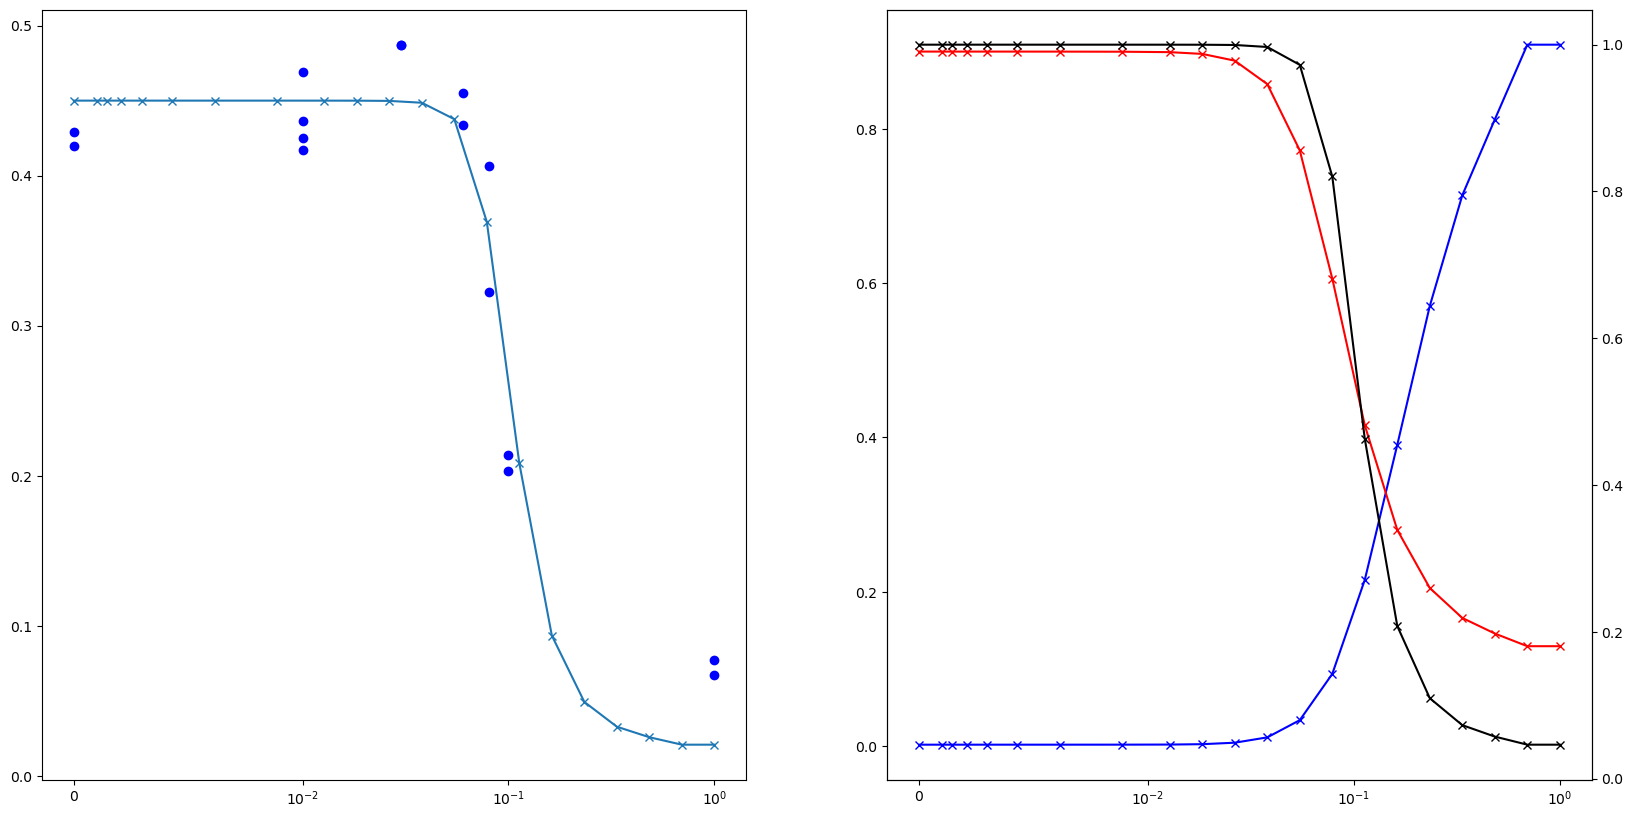

In [25]:
# Inverted Circuit

u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

kdegR = 0.042116
ktrans = 1.4514
kdegP = 12 / np.log(2) * 60
kdegPPDC = kdegP
K_Rep = 0.2
n_Rep = 2
mu_max_invert = 0.45 / 60


import matplotlib.pyplot as plt

ktrans_scaled = ktrans  * ((mu_max_invert + kdegP) / ktrans)
ss_Rep = - (1 / (2 * mu_max_invert)) * (kdegP - np.sqrt(4 * mRNA_arr * mu_max_invert * ktrans_scaled + kdegP ** 2))
# ktrans_scaled_invert = ktrans  * ((mu_max_invert + kdegP) / ktrans)
# dEnz_invert_dt = ktrans_scaled_invert * (K_Rep / (K_Rep + Rep)) * S / (Ks + S) - (kdegP + mu_x_invert) * Enz_invert
ktrans_scaled = ktrans  * ((mu_max_invert + kdegPPDC) / ktrans)
ss_Enz = - (1 / (2 * mu_max_invert)) * (kdegPPDC - np.sqrt(4 * (K_Rep ** n_Rep / (K_Rep ** n_Rep + ss_Rep ** n_Rep)) * mu_max_invert * ktrans_scaled + kdegPPDC ** 2))

mu_arr_invert = ss_Enz * mu_max_invert * 60

# Real Data
mu_SGy104_1 = np.array([0.429016493, 0.419454997, 0.425278485, 0.468815929, 0.214066814, 0.202848859, 0.077447387, 0.067285511, 0.487083379, 0.487241995,
0.436233624, 0.416734105, 0.433773399, 0.4552301, 0.406627518, 0.322757789])
mu_SGy104_1_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_invert, '-x', label='mu')
ax.plot(mu_SGy104_1_lights, mu_SGy104_1, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, ss_Rep, '-bx', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax2 = ax.twinx()
ax2.plot(u_arr, (K_Rep / (K_Rep + ss_Rep)), '-rx', label='mu')
ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


print(max(mu_arr_invert))
print(min(mu_arr_invert))
print(- (1 / (2 * mu_max_invert)) * (kdegP - np.sqrt(4 * (K_Rep / (K_Rep + ss_Rep[0])) * mu_max_invert * ktrans_scaled + kdegP ** 2)))

print(ss_Rep)
print(u_arr)


0.4423601998632875
0.0830435202510671


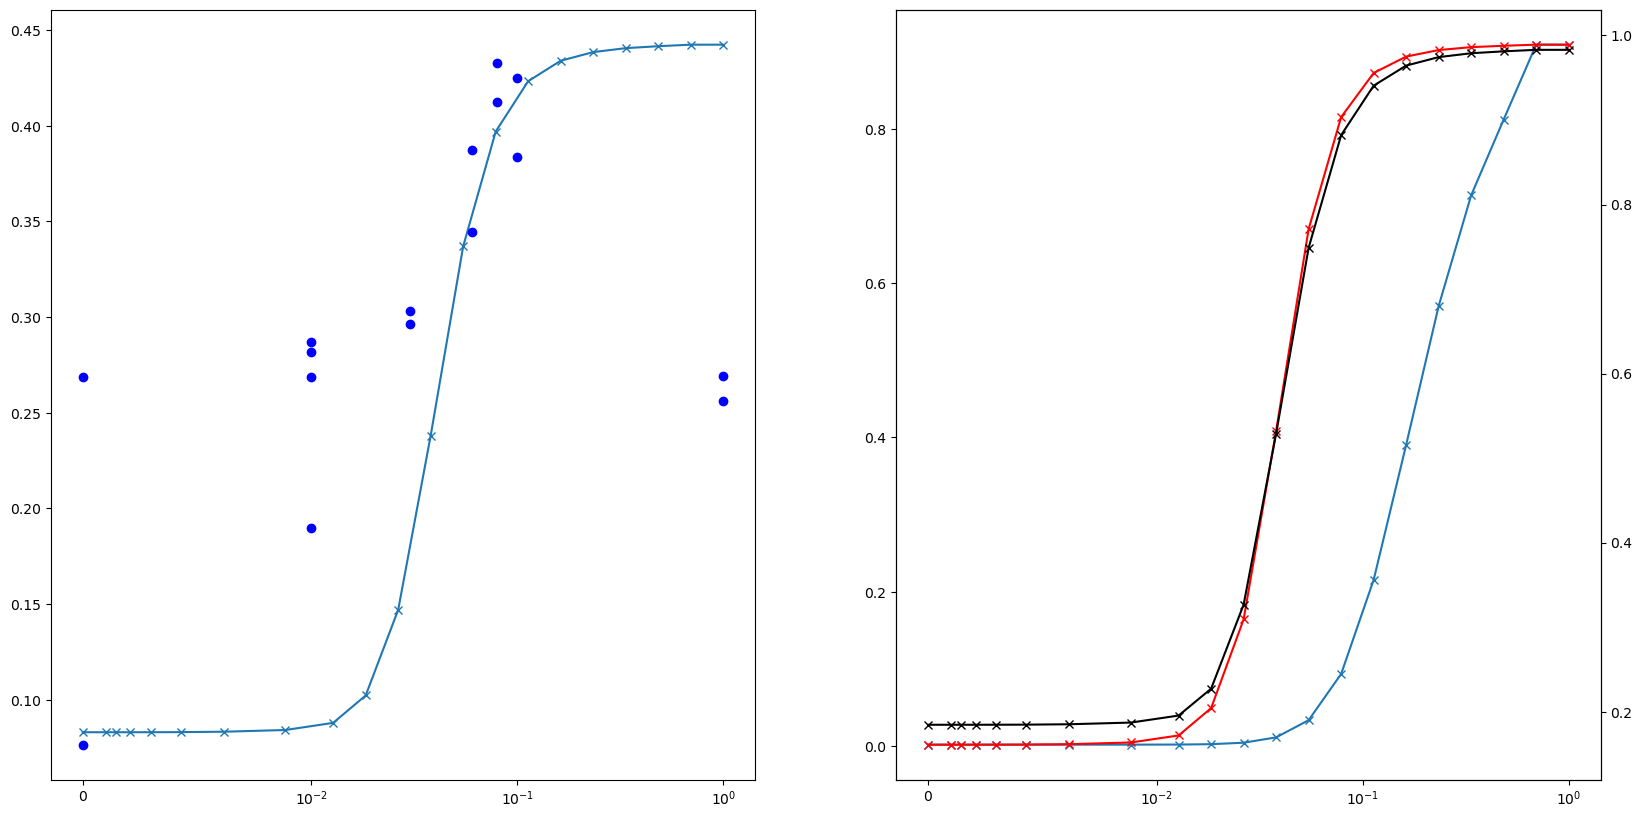

In [26]:
# Amp Circuit
K_Amp = 0.01
mu_max_amp = 0.45 / 60
n_Amp = 0.9

import matplotlib.pyplot as plt

ktrans_scaled = ktrans  * ((mu_max_amp + kdegP) / ktrans)
ss_Amp = - (1 / (2 * mu_max_amp)) * (kdegP - np.sqrt(4 * mRNA_arr * mu_max_amp * ktrans_scaled + kdegP ** 2))
ktrans_scaled = ktrans  * ((mu_max_amp + kdegPPDC) / ktrans)
ss_Enz = - (1 / (2 * mu_max_amp)) * (kdegPPDC - np.sqrt(4 * (ss_Amp ** n_Amp / (K_Amp ** n_Amp + ss_Amp ** n_Amp)) * mu_max_amp * ktrans_scaled + kdegPPDC ** 2))

mu_arr_amp = ss_Enz * mu_max_amp *60

# Real Data
mu_SGy128_4 = np.array([0.07654071, 0.26858448, 0.28688688, 0.19000113, 0.3834206 ,
       0.42503585, 0.25622547, 0.26932193, 0.30298274, 0.29615459,
       0.28158447, 0.26857221, 0.34449419, 0.38737338, 0.412247  ,
       0.43290314])
mu_SGy128_4_lags = np.array([ 0.        , 39.88279932, 19.98011315, 14.4137813 ,  0.        ,
        2.18260617,  0.        ,  1.21280087, 10.40812555,  7.77763666,
       21.22069601, 19.70771971,  1.68719277,  3.11811039,  2.52691981,
        2.30179095])
mu_SGy128_4_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_amp, '-x', label='mu')
ax.plot(mu_SGy128_4_lights, mu_SGy128_4, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, ss_Rep, '-x', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax2 = ax.twinx()
ax2.plot(u_arr, (ss_Amp / (K_Amp + ss_Amp)), '-rx', label='mu')
ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


print(max(mu_arr_amp))
print(min(mu_arr_amp))

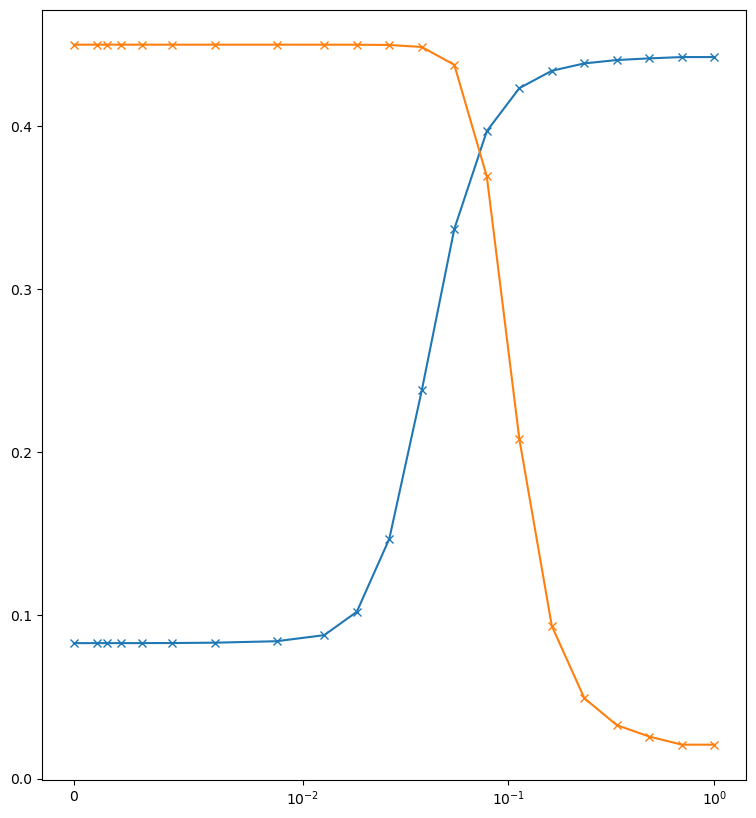

In [27]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_amp, '-x', label='mu_amp')
ax.plot(u_arr, mu_arr_invert, '-x', label='mu_invert')
ax.set_xscale('symlog', linthresh=0.01)

0
The solver successfully reached the end of the integration interval.
True


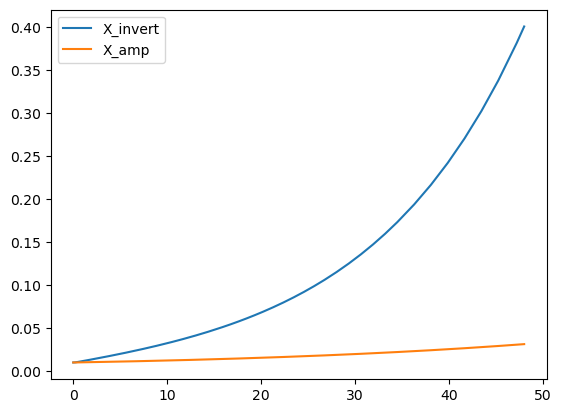

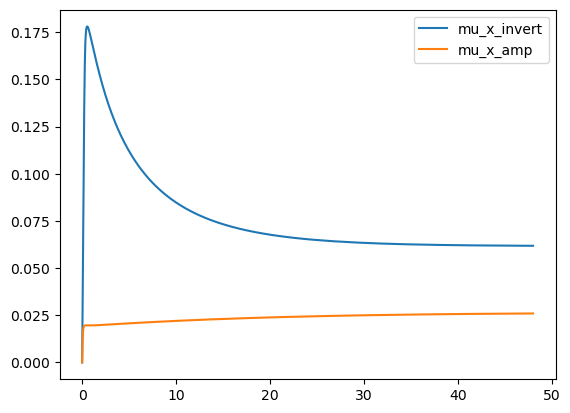

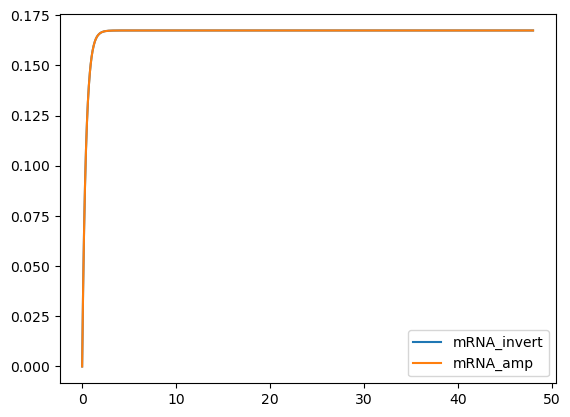

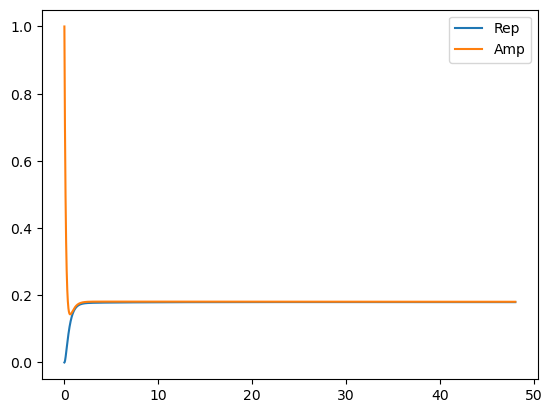

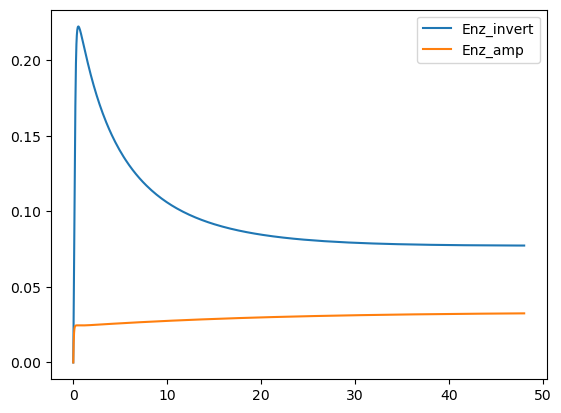

In [33]:
# kdegR = 0.042116
# ktrans = 1.4514
# kdegP = 0.1
# K_Rep = 0.05
# K_Amp = 0.99
# n_Rep = 4
# n_Amp = 4
# kdegPPDC = 0

# mu_max_invert = 0.45 / 60
# mu_max_amp = 0.45 / 60

# # mu_max = mu_max_opto
# Ks = 1
# Y = 0.5


t_final = 48

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
x_init = [0, 0, 0, 1, 0, 0, 20, 0.01, 0.01]


tspan = [0, t_final*60]
u = 0.1

period = 100 / 60
Imax = 1

setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

# print('my setpoint')
# print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u > 0:
    max_step = u*period
else:
    max_step = period / 10

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

print(sol.status)
print(sol.message)
print(sol.success)

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y



mRNA_invert = mRNA_invert_x
mRNA_amp = mRNA_amp_x
Rep = Rep_x
Amp = Amp_x
Enz_invert = Enz_invert_x
Enz_amp = Enz_amp_x
S = S_x
X_invert = X_invert_x
X_amp = X_amp_x
t_arr = sol.t

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

plt.figure(facecolor='white')
plt.plot(t_arr/60, X_invert, label='X_invert')
plt.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
plt.legend()

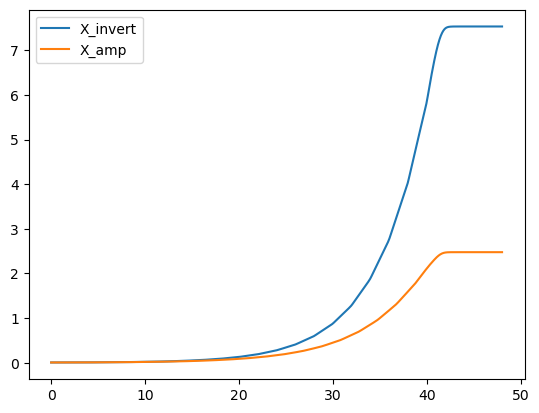

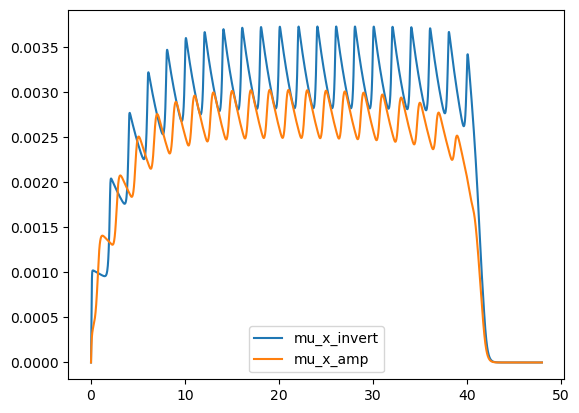

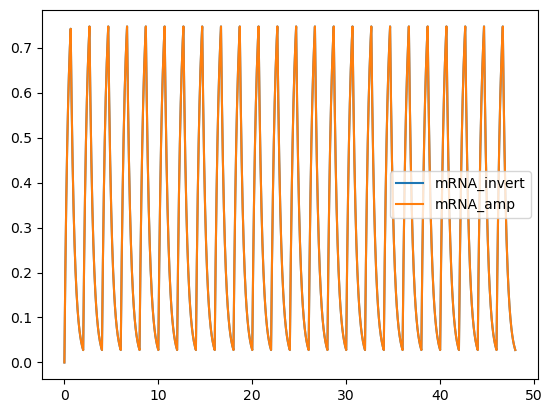

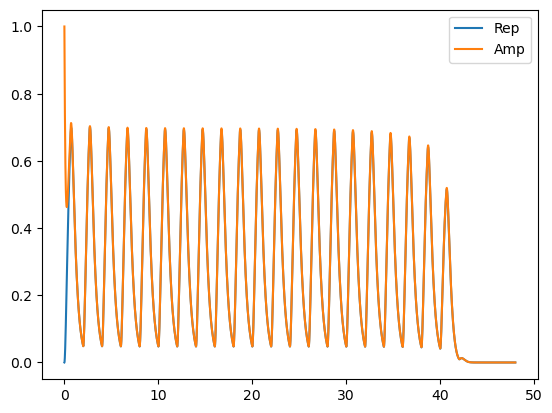

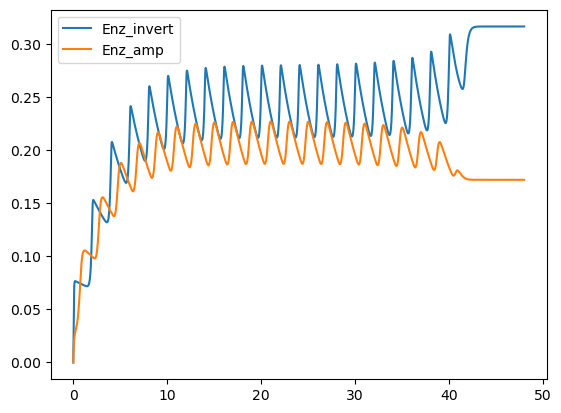

In [29]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.1
K_Rep = 0.05
K_Amp = 0.99
n_Rep = 4
n_Amp = 4
kdegPPDC = 0

mu_max_invert = 0.014
mu_max_amp = 0.014

# mu_max = mu_max_opto
Ks = 1
Y = 0.5


macro_period = 2
macro_pulse = 0.335
t_final = 48

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
x_init = [0, 0, 0, 1, 0, 0, 20, 0.005, 0.005]

t_span_arr = [0]
while t_span_arr[-1] < t_final * 60:
    last_t = t_span_arr[-1]
    t_span_arr.append(last_t + macro_pulse * macro_period * 60)
    t_span_arr.append(last_t + macro_period * 60)
tspan_arr = np.array(t_span_arr)
# tspan_arr = np.linspace(0, 24, 25) * 60
u_arr = [1, 0] * int((tspan_arr.size-1)/2)

mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = [], [], [], [], [], [], [], [], []
t_arr = []

for i in range(len(u_arr)):
    tspan = [tspan_arr[i], tspan_arr[i+1]]
    u = u_arr[i]

    period = 100 / 60
    Imax = 1

    setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

    # print('my setpoint')
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )
    x_init = sol.y[:,-1]

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

    mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y
    
    mRNA_invert.append(mRNA_invert_x)
    mRNA_amp.append(mRNA_amp_x)
    Rep.append(Rep_x)
    Amp.append(Amp_x)
    Enz_invert.append(Enz_invert_x)
    Enz_amp.append(Enz_amp_x)
    S.append(S_x)
    X_invert.append(X_invert_x)
    X_amp.append(X_amp_x)
    t_arr.append(sol.t)


mRNA_invert = np.hstack(mRNA_invert)
mRNA_amp = np.hstack(mRNA_amp)
Rep = np.hstack(Rep)
Amp = np.hstack(Amp)
Enz_invert = np.hstack(Enz_invert)
Enz_amp = np.hstack(Enz_amp)
S = np.hstack(S)
X_invert = np.hstack(X_invert)
X_amp = np.hstack(X_amp)
t_arr = np.hstack(t_arr)

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

plt.figure(facecolor='white')
plt.plot(t_arr/60, X_invert, label='X_invert')
plt.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
plt.legend()

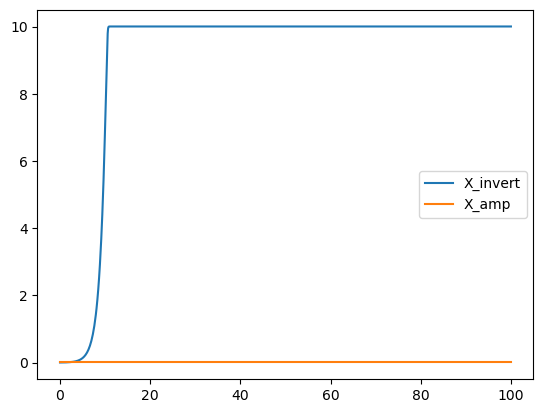

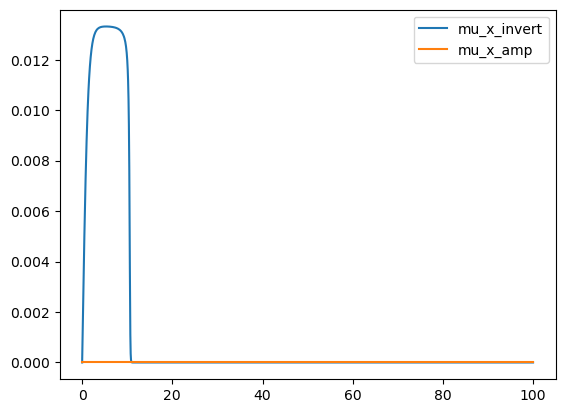

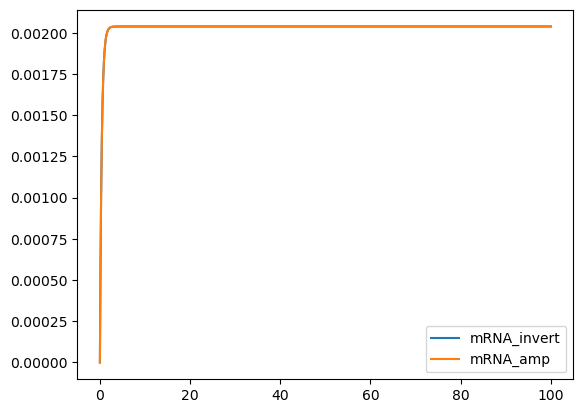

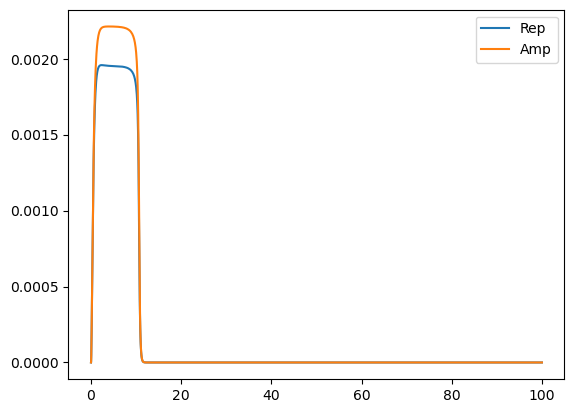

In [30]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.1
K_Rep = 0.05
K_Amp = 0.99
n_Rep = 4
n_Amp = 4
kdegPPDC = 0

mu_max_invert = 0.014
mu_max_amp = 0.014

# mu_max = mu_max_opto
Ks = 1
Y = 0.5


optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
x_init = [0, 0, 0, 0, 0, 0, 20, 0.005, 0.005]

tspan_arr = np.linspace(0, 100, 3) * 60
myu = 0.0119
u_arr = [myu, myu] * int((tspan_arr.size-1)/2)

mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = [], [], [], [], [], [], [], [], []
t_arr = []

for i in range(len(u_arr)):
    tspan = [tspan_arr[i], tspan_arr[i+1]]
    u = u_arr[i]

    period = 100 / 60
    Imax = 1

    setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

    # print('my setpoint')
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )
    x_init = sol.y[:,-1]

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

    mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y
    
    mRNA_invert.append(mRNA_invert_x)
    mRNA_amp.append(mRNA_amp_x)
    Rep.append(Rep_x)
    Amp.append(Amp_x)
    Enz_invert.append(Enz_invert_x)
    Enz_amp.append(Enz_amp_x)
    S.append(S_x)
    X_invert.append(X_invert_x)
    X_amp.append(X_amp_x)
    t_arr.append(sol.t)


mRNA_invert = np.hstack(mRNA_invert)
mRNA_amp = np.hstack(mRNA_amp)
Rep = np.hstack(Rep)
Amp = np.hstack(Amp)
Enz_invert = np.hstack(Enz_invert)
Enz_amp = np.hstack(Enz_amp)
S = np.hstack(S)
X_invert = np.hstack(X_invert)
X_amp = np.hstack(X_amp)
t_arr = np.hstack(t_arr)

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

plt.figure(facecolor='white')
plt.plot(t_arr/60, X_invert, label='X_invert')
plt.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

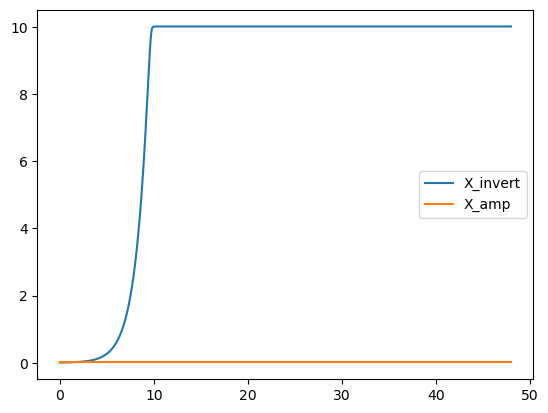

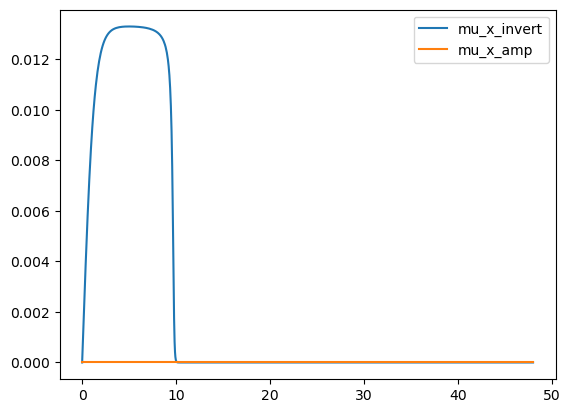

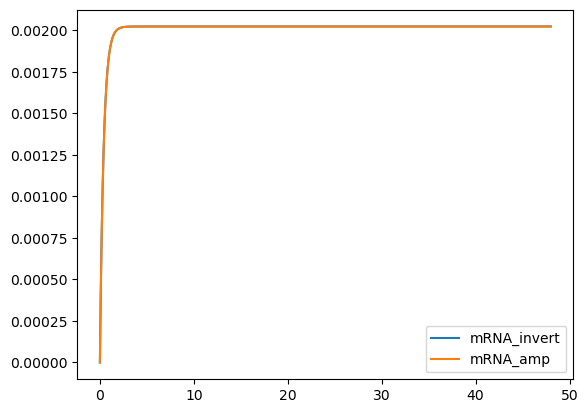

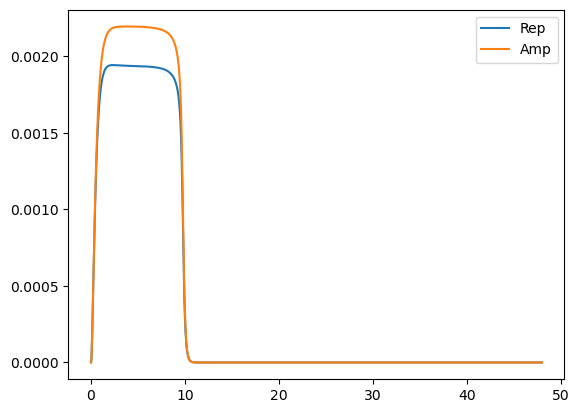

In [31]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.1
K_Rep = 0.05
K_Amp = 0.99
n_Rep = 4
n_Amp = 4
kdegPPDC = 0

mu_max_invert = 0.014
mu_max_amp = 0.014

# mu_max = mu_max_opto
Ks = 1
Y = 0.5


optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
x_init = [0, 0, 0, 0, 0, 0, 20, 0.01, 0.01]

tspan_arr = np.linspace(0, 48, 3) * 60
u_arr = [0.0115, 0.0115] * int((tspan_arr.size-1)/2)

mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = [], [], [], [], [], [], [], [], []
t_arr = []

for i in range(len(u_arr)):
    tspan = [tspan_arr[i], tspan_arr[i+1]]
    u = u_arr[i]

    period = 100 / 60
    Imax = 1

    setpoint = steady_mRNA_solve(u, period, Imax, x_guess=None)

    # print('my setpoint')
    # print(setpoint)

    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p,),
                        rtol=1e-6, atol=1e-9, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        # max_step=max_step,
                        )
    x_init = sol.y[:,-1]

    # print(sol.status)
    # print(sol.message)
    # print(sol.success)

    mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, X_invert_x, X_amp_x = sol.y
    
    mRNA_invert.append(mRNA_invert_x)
    mRNA_amp.append(mRNA_amp_x)
    Rep.append(Rep_x)
    Amp.append(Amp_x)
    Enz_invert.append(Enz_invert_x)
    Enz_amp.append(Enz_amp_x)
    S.append(S_x)
    X_invert.append(X_invert_x)
    X_amp.append(X_amp_x)
    t_arr.append(sol.t)


mRNA_invert = np.hstack(mRNA_invert)
mRNA_amp = np.hstack(mRNA_amp)
Rep = np.hstack(Rep)
Amp = np.hstack(Amp)
Enz_invert = np.hstack(Enz_invert)
Enz_amp = np.hstack(Enz_amp)
S = np.hstack(S)
X_invert = np.hstack(X_invert)
X_amp = np.hstack(X_amp)
t_arr = np.hstack(t_arr)

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

plt.figure(facecolor='white')
plt.plot(t_arr/60, X_invert, label='X_invert')
plt.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()